In [1]:
!kaggle datasets download -d gpiosenka/100-bird-species

100%|█████████████████████████████████████▉| 1.54G/1.54G [03:44<00:00, 8.56MB/s]
100%|██████████████████████████████████████| 1.54G/1.54G [03:44<00:00, 7.37MB/s]


In [2]:
!unzip -q 100-bird-species.zip

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
logical = tf.config.list_logical_devices('GPU')
print(len(gpus), 'Physical GPUs', len(logical), 'Logical GPUs')

1 Physical GPUs 1 Logical GPUs


In [2]:
generator = ImageDataGenerator()
batches   = generator.flow_from_directory('./100-bird-species/train')

Found 35215 images belonging to 250 classes.


In [3]:
indices = batches.class_indices

labels  = list(indices.keys())
labels

['AFRICAN CROWNED CRANE',
 'AFRICAN FIREFINCH',
 'ALBATROSS',
 'ALEXANDRINE PARAKEET',
 'AMERICAN AVOCET',
 'AMERICAN BITTERN',
 'AMERICAN COOT',
 'AMERICAN GOLDFINCH',
 'AMERICAN KESTREL',
 'AMERICAN PIPIT',
 'AMERICAN REDSTART',
 'ANHINGA',
 'ANNAS HUMMINGBIRD',
 'ANTBIRD',
 'ARARIPE MANAKIN',
 'ASIAN CRESTED IBIS',
 'BALD EAGLE',
 'BALI STARLING',
 'BALTIMORE ORIOLE',
 'BANANAQUIT',
 'BANDED BROADBILL',
 'BAR-TAILED GODWIT',
 'BARN OWL',
 'BARN SWALLOW',
 'BARRED PUFFBIRD',
 'BAY-BREASTED WARBLER',
 'BEARDED BARBET',
 'BELTED KINGFISHER',
 'BIRD OF PARADISE',
 'BLACK FRANCOLIN',
 'BLACK SKIMMER',
 'BLACK SWAN',
 'BLACK THROATED WARBLER',
 'BLACK VULTURE',
 'BLACK-CAPPED CHICKADEE',
 'BLACK-NECKED GREBE',
 'BLACK-THROATED SPARROW',
 'BLACKBURNIAM WARBLER',
 'BLUE GROUSE',
 'BLUE HERON',
 'BOBOLINK',
 'BROWN NOODY',
 'BROWN THRASHER',
 'CACTUS WREN',
 'CALIFORNIA CONDOR',
 'CALIFORNIA GULL',
 'CALIFORNIA QUAIL',
 'CANARY',
 'CAPE MAY WARBLER',
 'CAPUCHINBIRD',
 'CARMINE BEE-EATER',
 '

(32, 256, 256, 3)


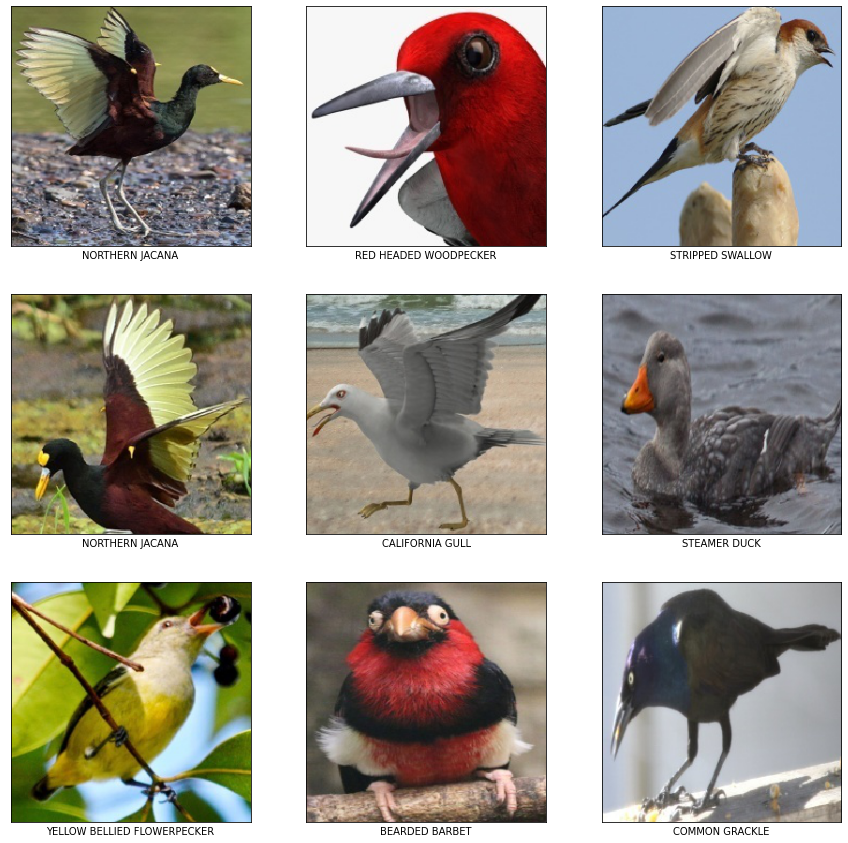

In [4]:
plt.figure(figsize=(15, 15))
for X, y in batches:
  print(X.shape)
  for i in range(9):
    plt.subplot(3, 3, i+1)
    img = X[i].astype(np.int32)
    label = labels[np.argmax(y[i])]
    plt.imshow(img)
    plt.xlabel(str(label))
    plt.xticks([])
    plt.yticks([])

  # plt.show()
  break

In [5]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   zoom_range=0.2,
                                   shear_range=0.2,
                                   rotation_range=30,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1.0/255)

test_datagen  = ImageDataGenerator(rescale=1.0/255)

In [6]:
train_generator = train_datagen.flow_from_directory('./100-bird-species/train',
                                                    target_size=(224,224),
                                                    color_mode='rgb',
                                                    class_mode='sparse',
                                                    batch_size=32)

val_generator = valid_datagen.flow_from_directory('./100-bird-species/valid',
                                                  target_size=(224,224),
                                                  color_mode='rgb',
                                                  class_mode='sparse',
                                                  batch_size=32)

test_generator = test_datagen.flow_from_directory('./100-bird-species/test',
                                                  target_size=(224,224),
                                                  color_mode='rgb',
                                                  class_mode='sparse',
                                                  batch_size=32)

Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.


In [7]:
def build_model():
  model = keras.Sequential()
  model.add(keras.applications.ResNet101V2(input_shape=(224,224,3), weights='imagenet', include_top=False))
  model.add(keras.layers.GlobalAveragePooling2D())
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Dense(2048, kernel_initializer='he_uniform'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Activation('relu'))
  model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Dense(1024, kernel_initializer='he_uniform'))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Activation('relu'))
  model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Dense(250, activation='softmax'))
  
  optimizer = keras.optimizers.Adam(lr=0.001)
  model.compile(optimizer=optimizer, metrics=['accuracy'], loss='sparse_categorical_crossentropy')
  return model


keras.backend.clear_session()
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Functional)     (None, 7, 7, 2048)        42626560  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
activation (Activation)      (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0

In [8]:
checkpoint = keras.callbacks.ModelCheckpoint('./bird-species.h5',
                                             monitor='val_accuracy',
                                             mode='max',
                                             save_best_only=True, 
                                             verbose=1)

model_history = model.fit(train_generator,
                          validation_data=val_generator,
                          epochs=500,
                          callbacks=[checkpoint],
                          verbose=1)

Epoch 1/500
1101/1101 [==============================] - ETA: 0s - loss: 5.9594 - accuracy: 0.0066
Epoch 00001: val_accuracy improved from -inf to 0.00320, saving model to ./bird-species.h5
1101/1101 [==============================] - 311s 283ms/step - loss: 5.9594 - accuracy: 0.0066 - val_loss: 67.1617 - val_accuracy: 0.0032
Epoch 2/500
1101/1101 [==============================] - ETA: 0s - loss: 5.8137 - accuracy: 0.0081
Epoch 00002: val_accuracy improved from 0.00320 to 0.00960, saving model to ./bird-species.h5
1101/1101 [==============================] - 297s 270ms/step - loss: 5.8137 - accuracy: 0.0081 - val_loss: 39.1197 - val_accuracy: 0.0096
Epoch 3/500
1101/1101 [==============================] - ETA: 0s - loss: 5.5620 - accuracy: 0.0131
Epoch 00003: val_accuracy improved from 0.00960 to 0.01120, saving model to ./bird-species.h5
1101/1101 [==============================] - 303s 275ms/step - loss: 5.5620 - accuracy: 0.0131 - val_loss: 5.1207 - val_accuracy: 0.0112
Epoch 4/500

Epoch 27/500
1101/1101 [==============================] - ETA: 0s - loss: 1.7205 - accuracy: 0.5556
Epoch 00027: val_accuracy did not improve from 0.67200
1101/1101 [==============================] - 302s 274ms/step - loss: 1.7205 - accuracy: 0.5556 - val_loss: 1.4584 - val_accuracy: 0.6528
Epoch 28/500
1101/1101 [==============================] - ETA: 0s - loss: 1.5922 - accuracy: 0.5826
Epoch 00028: val_accuracy improved from 0.67200 to 0.71840, saving model to ./bird-species.h5
1101/1101 [==============================] - 306s 278ms/step - loss: 1.5922 - accuracy: 0.5826 - val_loss: 21.1532 - val_accuracy: 0.7184
Epoch 29/500
1101/1101 [==============================] - ETA: 0s - loss: 1.5502 - accuracy: 0.5953
Epoch 00029: val_accuracy did not improve from 0.71840
1101/1101 [==============================] - 302s 274ms/step - loss: 1.5502 - accuracy: 0.5953 - val_loss: 12.9380 - val_accuracy: 0.7000
Epoch 30/500
1101/1101 [==============================] - ETA: 0s - loss: 1.4803 - 

Epoch 54/500
1101/1101 [==============================] - ETA: 0s - loss: 0.6303 - accuracy: 0.8177
Epoch 00054: val_accuracy did not improve from 0.87760
1101/1101 [==============================] - 285s 259ms/step - loss: 0.6303 - accuracy: 0.8177 - val_loss: 1.3695 - val_accuracy: 0.7872
Epoch 55/500
1101/1101 [==============================] - ETA: 0s - loss: 0.6122 - accuracy: 0.8213
Epoch 00055: val_accuracy did not improve from 0.87760
1101/1101 [==============================] - 285s 258ms/step - loss: 0.6122 - accuracy: 0.8213 - val_loss: 3.6720 - val_accuracy: 0.8016
Epoch 56/500
1101/1101 [==============================] - ETA: 0s - loss: 0.6128 - accuracy: 0.8229
Epoch 00056: val_accuracy did not improve from 0.87760
1101/1101 [==============================] - 285s 259ms/step - loss: 0.6128 - accuracy: 0.8229 - val_loss: 1.9895 - val_accuracy: 0.8616
Epoch 57/500
1101/1101 [==============================] - ETA: 0s - loss: 0.5822 - accuracy: 0.8318
Epoch 00057: val_accurac

Epoch 82/500
1101/1101 [==============================] - ETA: 0s - loss: 0.3279 - accuracy: 0.9008
Epoch 00082: val_accuracy did not improve from 0.91040
1101/1101 [==============================] - 285s 258ms/step - loss: 0.3279 - accuracy: 0.9008 - val_loss: 0.4564 - val_accuracy: 0.8880
Epoch 83/500
1101/1101 [==============================] - ETA: 0s - loss: 0.3275 - accuracy: 0.9010
Epoch 00083: val_accuracy did not improve from 0.91040
1101/1101 [==============================] - 285s 259ms/step - loss: 0.3275 - accuracy: 0.9010 - val_loss: 0.6082 - val_accuracy: 0.8640
Epoch 84/500
1101/1101 [==============================] - ETA: 0s - loss: 0.3182 - accuracy: 0.9033
Epoch 00084: val_accuracy did not improve from 0.91040
1101/1101 [==============================] - 285s 259ms/step - loss: 0.3182 - accuracy: 0.9033 - val_loss: 0.5267 - val_accuracy: 0.8672
Epoch 85/500
1101/1101 [==============================] - ETA: 0s - loss: 0.3164 - accuracy: 0.9033
Epoch 00085: val_accurac

Epoch 110/500
1101/1101 [==============================] - ETA: 0s - loss: 0.2122 - accuracy: 0.9357
Epoch 00110: val_accuracy did not improve from 0.93200
1101/1101 [==============================] - 285s 258ms/step - loss: 0.2122 - accuracy: 0.9357 - val_loss: 0.3412 - val_accuracy: 0.9272
Epoch 111/500
1101/1101 [==============================] - ETA: 0s - loss: 0.2064 - accuracy: 0.9364
Epoch 00111: val_accuracy did not improve from 0.93200
1101/1101 [==============================] - 285s 259ms/step - loss: 0.2064 - accuracy: 0.9364 - val_loss: 0.3857 - val_accuracy: 0.9160
Epoch 112/500
1101/1101 [==============================] - ETA: 0s - loss: 0.2110 - accuracy: 0.9358
Epoch 00112: val_accuracy did not improve from 0.93200
1101/1101 [==============================] - 285s 259ms/step - loss: 0.2110 - accuracy: 0.9358 - val_loss: 0.5050 - val_accuracy: 0.8824
Epoch 113/500
1101/1101 [==============================] - ETA: 0s - loss: 0.1945 - accuracy: 0.9395
Epoch 00113: val_acc

Epoch 138/500
1101/1101 [==============================] - ETA: 0s - loss: 0.1588 - accuracy: 0.9510
Epoch 00138: val_accuracy did not improve from 0.94080
1101/1101 [==============================] - 285s 259ms/step - loss: 0.1588 - accuracy: 0.9510 - val_loss: 0.4324 - val_accuracy: 0.9152
Epoch 139/500
1101/1101 [==============================] - ETA: 0s - loss: 0.1511 - accuracy: 0.9535
Epoch 00139: val_accuracy did not improve from 0.94080
1101/1101 [==============================] - 285s 259ms/step - loss: 0.1511 - accuracy: 0.9535 - val_loss: 0.4051 - val_accuracy: 0.9168
Epoch 140/500
1101/1101 [==============================] - ETA: 0s - loss: 0.1540 - accuracy: 0.9529
Epoch 00140: val_accuracy improved from 0.94080 to 0.94160, saving model to ./bird-species.h5
1101/1101 [==============================] - 290s 264ms/step - loss: 0.1540 - accuracy: 0.9529 - val_loss: 0.2799 - val_accuracy: 0.9416
Epoch 141/500
1101/1101 [==============================] - ETA: 0s - loss: 0.1532 

Epoch 166/500
1101/1101 [==============================] - ETA: 0s - loss: 0.1229 - accuracy: 0.9617
Epoch 00166: val_accuracy did not improve from 0.94240
1101/1101 [==============================] - 285s 259ms/step - loss: 0.1229 - accuracy: 0.9617 - val_loss: 0.6153 - val_accuracy: 0.8936
Epoch 167/500
1101/1101 [==============================] - ETA: 0s - loss: 0.1256 - accuracy: 0.9615
Epoch 00167: val_accuracy did not improve from 0.94240
1101/1101 [==============================] - 285s 259ms/step - loss: 0.1256 - accuracy: 0.9615 - val_loss: 0.3579 - val_accuracy: 0.9296
Epoch 168/500
1101/1101 [==============================] - ETA: 0s - loss: 0.1259 - accuracy: 0.9626
Epoch 00168: val_accuracy did not improve from 0.94240
1101/1101 [==============================] - 285s 259ms/step - loss: 0.1259 - accuracy: 0.9626 - val_loss: 1.3439 - val_accuracy: 0.8256
Epoch 169/500
1101/1101 [==============================] - ETA: 0s - loss: 0.1232 - accuracy: 0.9625
Epoch 00169: val_acc

Epoch 194/500
1101/1101 [==============================] - ETA: 0s - loss: 0.1017 - accuracy: 0.9698
Epoch 00194: val_accuracy did not improve from 0.95120
1101/1101 [==============================] - 285s 259ms/step - loss: 0.1017 - accuracy: 0.9698 - val_loss: 0.3411 - val_accuracy: 0.9416
Epoch 195/500
1101/1101 [==============================] - ETA: 0s - loss: 0.1084 - accuracy: 0.9677
Epoch 00195: val_accuracy did not improve from 0.95120
1101/1101 [==============================] - 285s 259ms/step - loss: 0.1084 - accuracy: 0.9677 - val_loss: 0.4244 - val_accuracy: 0.9288
Epoch 196/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0983 - accuracy: 0.9701
Epoch 00196: val_accuracy did not improve from 0.95120
1101/1101 [==============================] - 285s 259ms/step - loss: 0.0983 - accuracy: 0.9701 - val_loss: 0.3630 - val_accuracy: 0.9360
Epoch 197/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0962 - accuracy: 0.9715
Epoch 00197: val_acc

Epoch 222/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0888 - accuracy: 0.9726
Epoch 00222: val_accuracy did not improve from 0.95120
1101/1101 [==============================] - 285s 259ms/step - loss: 0.0888 - accuracy: 0.9726 - val_loss: 1.6261 - val_accuracy: 0.7904
Epoch 223/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0842 - accuracy: 0.9749
Epoch 00223: val_accuracy did not improve from 0.95120
1101/1101 [==============================] - 285s 259ms/step - loss: 0.0842 - accuracy: 0.9749 - val_loss: 0.6611 - val_accuracy: 0.8928
Epoch 224/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0885 - accuracy: 0.9741
Epoch 00224: val_accuracy did not improve from 0.95120
1101/1101 [==============================] - 285s 259ms/step - loss: 0.0885 - accuracy: 0.9741 - val_loss: 0.5269 - val_accuracy: 0.9280
Epoch 225/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0847 - accuracy: 0.9741
Epoch 00225: val_acc

Epoch 250/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0793 - accuracy: 0.9763
Epoch 00250: val_accuracy did not improve from 0.95360
1101/1101 [==============================] - 285s 259ms/step - loss: 0.0793 - accuracy: 0.9763 - val_loss: 0.2556 - val_accuracy: 0.9472
Epoch 251/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0744 - accuracy: 0.9776
Epoch 00251: val_accuracy did not improve from 0.95360
1101/1101 [==============================] - 285s 259ms/step - loss: 0.0744 - accuracy: 0.9776 - val_loss: 0.3057 - val_accuracy: 0.9408
Epoch 252/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0855 - accuracy: 0.9757
Epoch 00252: val_accuracy did not improve from 0.95360
1101/1101 [==============================] - 285s 259ms/step - loss: 0.0855 - accuracy: 0.9757 - val_loss: 0.6256 - val_accuracy: 0.9216
Epoch 253/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0750 - accuracy: 0.9780
Epoch 00253: val_acc

Epoch 278/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0711 - accuracy: 0.9789
Epoch 00278: val_accuracy did not improve from 0.95360
1101/1101 [==============================] - 285s 258ms/step - loss: 0.0711 - accuracy: 0.9789 - val_loss: 0.5881 - val_accuracy: 0.9144
Epoch 279/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0682 - accuracy: 0.9795
Epoch 00279: val_accuracy did not improve from 0.95360
1101/1101 [==============================] - 285s 258ms/step - loss: 0.0682 - accuracy: 0.9795 - val_loss: 1.0688 - val_accuracy: 0.8872
Epoch 280/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0654 - accuracy: 0.9796
Epoch 00280: val_accuracy did not improve from 0.95360
1101/1101 [==============================] - 285s 259ms/step - loss: 0.0654 - accuracy: 0.9796 - val_loss: 0.4432 - val_accuracy: 0.9368
Epoch 281/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0713 - accuracy: 0.9802
Epoch 00281: val_acc

Epoch 306/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0596 - accuracy: 0.9824
Epoch 00306: val_accuracy did not improve from 0.95520
1101/1101 [==============================] - 285s 259ms/step - loss: 0.0596 - accuracy: 0.9824 - val_loss: 0.3264 - val_accuracy: 0.9528
Epoch 307/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0592 - accuracy: 0.9825
Epoch 00307: val_accuracy did not improve from 0.95520
1101/1101 [==============================] - 285s 259ms/step - loss: 0.0592 - accuracy: 0.9825 - val_loss: 0.3128 - val_accuracy: 0.9488
Epoch 308/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0658 - accuracy: 0.9807
Epoch 00308: val_accuracy did not improve from 0.95520
1101/1101 [==============================] - 285s 259ms/step - loss: 0.0658 - accuracy: 0.9807 - val_loss: 0.5822 - val_accuracy: 0.9128
Epoch 309/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0626 - accuracy: 0.9805
Epoch 00309: val_acc

Epoch 334/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0569 - accuracy: 0.9836
Epoch 00334: val_accuracy did not improve from 0.95520
1101/1101 [==============================] - 285s 259ms/step - loss: 0.0569 - accuracy: 0.9836 - val_loss: 0.4070 - val_accuracy: 0.9480
Epoch 335/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0559 - accuracy: 0.9839
Epoch 00335: val_accuracy did not improve from 0.95520
1101/1101 [==============================] - 285s 259ms/step - loss: 0.0559 - accuracy: 0.9839 - val_loss: 0.3678 - val_accuracy: 0.9520
Epoch 336/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0607 - accuracy: 0.9821
Epoch 00336: val_accuracy did not improve from 0.95520
1101/1101 [==============================] - 285s 259ms/step - loss: 0.0607 - accuracy: 0.9821 - val_loss: 0.3940 - val_accuracy: 0.9528
Epoch 337/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0562 - accuracy: 0.9836
Epoch 00337: val_acc

Epoch 362/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0610 - accuracy: 0.9836
Epoch 00362: val_accuracy did not improve from 0.95520
1101/1101 [==============================] - 285s 259ms/step - loss: 0.0610 - accuracy: 0.9836 - val_loss: 0.3699 - val_accuracy: 0.9424
Epoch 363/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0516 - accuracy: 0.9846
Epoch 00363: val_accuracy did not improve from 0.95520
1101/1101 [==============================] - 285s 259ms/step - loss: 0.0516 - accuracy: 0.9846 - val_loss: 0.4122 - val_accuracy: 0.9368
Epoch 364/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0578 - accuracy: 0.9839
Epoch 00364: val_accuracy did not improve from 0.95520
1101/1101 [==============================] - 285s 259ms/step - loss: 0.0578 - accuracy: 0.9839 - val_loss: 0.6248 - val_accuracy: 0.9176
Epoch 365/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0552 - accuracy: 0.9839
Epoch 00365: val_acc

Epoch 390/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0467 - accuracy: 0.9865
Epoch 00390: val_accuracy did not improve from 0.95680
1101/1101 [==============================] - 285s 258ms/step - loss: 0.0467 - accuracy: 0.9865 - val_loss: 0.4183 - val_accuracy: 0.9384
Epoch 391/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0513 - accuracy: 0.9848
Epoch 00391: val_accuracy did not improve from 0.95680
1101/1101 [==============================] - 285s 259ms/step - loss: 0.0513 - accuracy: 0.9848 - val_loss: 0.2836 - val_accuracy: 0.9568
Epoch 392/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0506 - accuracy: 0.9856
Epoch 00392: val_accuracy did not improve from 0.95680
1101/1101 [==============================] - 285s 259ms/step - loss: 0.0506 - accuracy: 0.9856 - val_loss: 0.3628 - val_accuracy: 0.9496
Epoch 393/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0505 - accuracy: 0.9858
Epoch 00393: val_acc

Epoch 418/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0563 - accuracy: 0.9846
Epoch 00418: val_accuracy did not improve from 0.95920
1101/1101 [==============================] - 285s 259ms/step - loss: 0.0563 - accuracy: 0.9846 - val_loss: 0.5907 - val_accuracy: 0.9328
Epoch 419/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0497 - accuracy: 0.9852
Epoch 00419: val_accuracy did not improve from 0.95920
1101/1101 [==============================] - 296s 269ms/step - loss: 0.0497 - accuracy: 0.9852 - val_loss: 0.4184 - val_accuracy: 0.9504
Epoch 420/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0485 - accuracy: 0.9861
Epoch 00420: val_accuracy did not improve from 0.95920
1101/1101 [==============================] - 287s 261ms/step - loss: 0.0485 - accuracy: 0.9861 - val_loss: 0.6655 - val_accuracy: 0.9400
Epoch 421/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0489 - accuracy: 0.9864
Epoch 00421: val_acc

Epoch 446/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0464 - accuracy: 0.9867
Epoch 00446: val_accuracy did not improve from 0.96000
1101/1101 [==============================] - 289s 263ms/step - loss: 0.0464 - accuracy: 0.9867 - val_loss: 0.4479 - val_accuracy: 0.9472
Epoch 447/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0462 - accuracy: 0.9865
Epoch 00447: val_accuracy did not improve from 0.96000
1101/1101 [==============================] - 292s 265ms/step - loss: 0.0462 - accuracy: 0.9865 - val_loss: 0.4967 - val_accuracy: 0.9328
Epoch 448/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0464 - accuracy: 0.9870
Epoch 00448: val_accuracy did not improve from 0.96000
1101/1101 [==============================] - 294s 267ms/step - loss: 0.0464 - accuracy: 0.9870 - val_loss: 0.3506 - val_accuracy: 0.9568
Epoch 449/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0501 - accuracy: 0.9862
Epoch 00449: val_acc

Epoch 474/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0429 - accuracy: 0.9877
Epoch 00474: val_accuracy did not improve from 0.96000
1101/1101 [==============================] - 285s 258ms/step - loss: 0.0429 - accuracy: 0.9877 - val_loss: 0.5467 - val_accuracy: 0.9512
Epoch 475/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0497 - accuracy: 0.9864
Epoch 00475: val_accuracy did not improve from 0.96000
1101/1101 [==============================] - 290s 263ms/step - loss: 0.0497 - accuracy: 0.9864 - val_loss: 0.4888 - val_accuracy: 0.9472
Epoch 476/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0446 - accuracy: 0.9869
Epoch 00476: val_accuracy improved from 0.96000 to 0.96080, saving model to ./bird-species.h5
1101/1101 [==============================] - 293s 266ms/step - loss: 0.0446 - accuracy: 0.9869 - val_loss: 0.3975 - val_accuracy: 0.9608
Epoch 477/500
1101/1101 [==============================] - ETA: 0s - loss: 0.0433 

In [10]:
model.save('./bird-species-last.h5')

In [11]:
model.evaluate(test_gemerator)

40/40 [==============================] - 3s 84ms/step - loss: 0.3609 - accuracy: 0.9456


[0.3608725666999817, 0.9455999732017517]

In [12]:
model.load_weights('./bird-species.h5')
model.evaluate(test_gemerator)

40/40 [==============================] - 3s 78ms/step - loss: 0.1951 - accuracy: 0.9720


[0.19512559473514557, 0.972000002861023]